In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir_data = "/content/drive/MyDrive"

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

In [4]:
ny, nx = img_label.size
nframe = img_label.n_frames

In [5]:
nframe_train = 24
nframe_val = 3
nframe_test = 3

dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

if not os.path.exists(dir_save_train):
  os.makedirs(dir_save_train)

if not os.path.exists(dir_save_val):
  os.makedirs(dir_save_val)

if not os.path.exists(dir_save_test):
  os.makedirs(dir_save_test)

In [6]:
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)

In [7]:
offset_nframe = 0

for i in range(nframe_train):
  img_label.seek(id_frame[i + offset_nframe])
  img_input.seek(id_frame[i + offset_nframe])

  label_ = np.asarray(img_label)
  input_ = np.asarray(img_input)

  np.save(os.path.join(dir_save_train, 'label_%03d.npy' % i), label_)
  np.save(os.path.join(dir_save_train, 'input_%03d.npy' % i), input_)

offset_nframe += nframe_train

for i in range(nframe_val):
  img_label.seek(id_frame[i + offset_nframe])
  img_input.seek(id_frame[i + offset_nframe])

  label_ = np.asarray(img_label)
  input_ = np.asarray(img_input)

  np.save(os.path.join(dir_save_val, 'label_%03d.npy' % i), label_)
  np.save(os.path.join(dir_save_val, 'input_%03d.npy' % i), input_)

offset_nframe += nframe_val

for i in range(nframe_test):
  img_label.seek(id_frame[i + offset_nframe])
  img_input.seek(id_frame[i + offset_nframe])

  label_ = np.asarray(img_label)
  input_ = np.asarray(img_input)

  np.save(os.path.join(dir_save_test, 'label_%03d.npy' % i), label_)
  np.save(os.path.join(dir_save_test, 'input_%03d.npy' % i), input_)

<function matplotlib.pyplot.show(*args, **kw)>

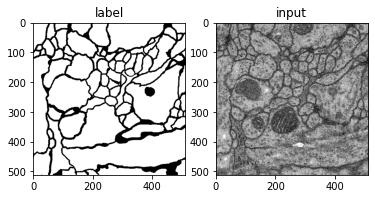

In [8]:
plt.subplot(121)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(122)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.show

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets

In [25]:
lr = 1e-3
batch_size = 4
num_epoch = 10

data_dir = '/content/drive/MyDrive'
ckpt_dir = '/content/drive/MyDrive/checkpoint'
log_dir = '/content/drive/MyDrive/log'
result_dir = '/content/drive/MyDrive/results'

if not os.path.exists(result_dir):
  os.makedirs(os.path.join(result_dir, 'png'))
  os.makedirs(os.path.join(result_dir, 'numpy'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
      layers = []
      layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
      layers += [nn.BatchNorm2d(num_features=out_channels)]
      layers += [nn.ReLU()]

      cbr = nn.Sequential(*layers)

      return cbr

    # Contracting path
    self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
    self.enc1_2 = CBR2d(in_channels=64, out_channels=64)
    
    self.pool1 = nn.MaxPool2d(kernel_size=2)

    self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
    self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

    self.pool2 = nn.MaxPool2d(kernel_size=2)

    self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
    self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

    self.pool3 = nn.MaxPool2d(kernel_size=2)

    self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
    self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

    self.pool4 = nn.MaxPool2d(kernel_size=2)

    self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)
    
    # Expansive path
    self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

    self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)

    self.dec4_2 = CBR2d(in_channels=2*512, out_channels=512)
    self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

    self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)

    self.dec3_2 = CBR2d(in_channels=2*256, out_channels=256)
    self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

    self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)

    self.dec2_2 = CBR2d(in_channels=2*128, out_channels=128)
    self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

    self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)

    self.dec1_2 = CBR2d(in_channels=2*64, out_channels=64)
    self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

    self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
  
  def forward(self, x):
    enc1_1 = self.enc1_1(x)
    enc1_2 = self.enc1_2(enc1_1)
    pool1 = self.pool1(enc1_2)

    enc2_1 = self.enc2_1(pool1)
    enc2_2 = self.enc2_2(enc2_1)
    pool2 = self.pool2(enc2_2)

    enc3_1 = self.enc3_1(pool2)
    enc3_2 = self.enc3_2(enc3_1)
    pool3 = self.pool3(enc3_2)

    enc4_1 = self.enc4_1(pool3)
    enc4_2 = self.enc4_2(enc4_1)
    pool4 = self.pool4(enc4_2)

    enc5_1 = self.enc5_1(pool4)

    dec5_1 = self.dec5_1(enc5_1)

    unpool4 = self.unpool4(dec5_1)
    cat4 = torch.cat((unpool4, enc4_2), dim=1)
    dec4_2 = self.dec4_2(cat4)
    dec4_1 = self.dec4_1(dec4_2)

    unpool3 = self.unpool3(dec4_1)
    cat3 = torch.cat((unpool3, enc3_2), dim=1)
    dec3_2 = self.dec3_2(cat3)
    dec3_1 = self.dec3_1(dec3_2)

    unpool2 = self.unpool2(dec3_1)
    cat2 = torch.cat((unpool2, enc2_2), dim=1)
    dec2_2 = self.dec2_2(cat2)
    dec2_1 = self.dec2_1(dec2_2)

    unpool1 = self.unpool1(dec2_1)
    cat1 = torch.cat((unpool1, enc1_2), dim=1)
    dec1_2 = self.dec1_2(cat1)
    dec1_1 = self.dec1_1(dec1_2)

    fc = self.fc(dec1_1)

    return fc

In [12]:
# dataloader
class Dataset(torch.utils.data.Dataset):
  def __init__(self, data_dir, transform=None):
    self.data_dir = data_dir
    self.transform = transform

    lst_data = os.listdir(self.data_dir)

    lst_label = [f for f in lst_data if f.startswith('label')]
    lst_input = [f for f in lst_data if f.startswith('input')]

    lst_label.sort()
    lst_input.sort()

    self.lst_label = lst_label
    self.lst_input = lst_input

  def __len__(self):
    return len(self.lst_label)
  
  def __getitem__(self, index):
    label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
    input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

    # normalization in [0,1]
    label = label/255.0
    input = input/255.0

    # channel axis
    if label.ndim == 2:
      label = label[:, :, np.newaxis]
    if input.ndim == 2:
      input = input[:, :, np.newaxis]
  
    data = {'input': input, 'label': label}

    if self.transform:
      data = self.transform(data)

    return data 

In [13]:
# test for the dataloader
dataset_train = Dataset(data_dir = os.path.join(data_dir, 'train'))

In [14]:
data = dataset_train.__getitem__(0)

input = data['input']
label = data['label']


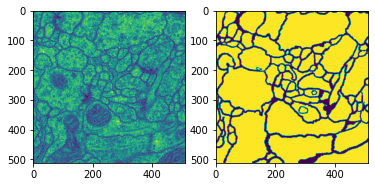

In [15]:
plt.subplot(121)
plt.imshow(input.squeeze())

plt.subplot(122)
plt.imshow(label.squeeze())

plt.show()

In [16]:
# transform
class ToTensor(object):
  def __call__(self, data):
    label, input = data['label'], data['input']

    # image(numpy): {Y, X, C}
    # image(tensor): {C, Y, X}
    label = label.transpose((2, 0, 1)).astype(np.float32)
    input = input.transpose((2, 0, 1)).astype(np.float32)

    data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

    return data

class Normalization(object):
  def __init__(self, mean=0.5, std=0.5):
    self.mean = mean
    self.std = std

  def __call__(self, data):
    label, input = data['label'], data['input']

    input = (input - self.mean) / self.std

    data = {'label': label, 'input': input}

    return data

class RandomFlip(object):
  def __call__(self, data):
    label, input = data['label'], data['input']

    if np.random.rand() > 0.5:
      label = np.fliplr(label)
      input = np.fliplr(input)

    if np.random.rand() > 0.5:
      label = np.flipud(label)
      input = np.flipud(input)

    data = {'label': label, 'input': input}

    return data

In [17]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)

data = dataset_train.__getitem__(0)

input = data['input']
label = data['label']

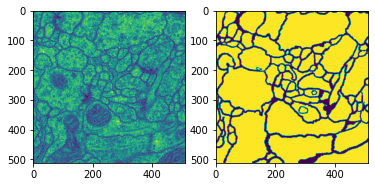

In [18]:
plt.subplot(121)
plt.imshow(input.squeeze())

plt.subplot(122)
plt.imshow(label.squeeze())

In [19]:
# training network
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
net = UNet().to(device)

## loss function
fn_loss = nn.BCEWithLogitsLoss().to(device)

## optimizer
optim = torch.optim.Adam(net.parameters(), lr=lr)

num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

# Tensorboard
writer_train = SummaryWriter(log_dir = os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir = os.path.join(log_dir, 'val'))

In [21]:
# store network
def save(ckpt_dir, net, optim, epoch):
  if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

  torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
             "/%s/model_epoch%d.pth" % (ckpt_dir, epoch))

In [22]:
# load network
def load(ckpt_dir, net, optim):
  if not os.path.exists(ckpt_dir):
    epoch = 0
    return net, optim, epoch
  ckpt_lst = os.listdir(ckpt_dir)

  ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

  dict_model = torch.load('/%s/%s' % (ckpt_dir, ckpt_lst[-1]))

  net.load_state_dict(dict_model['net'])
  optim.load_state_dict(dict_model['optim'])
  epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

  return net, optim, epoch

In [26]:
st_epoch = 0
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)


for epoch in range(st_epoch+1, num_epoch+1):
  net.train()
  loss_arr = []

  for batch, data in enumerate(loader_train, 1):
    # forward pass
    label = data['label'].to(device)
    input = data['input'].to(device)

    output = net(input)

    # backward pass
    optim.zero_grad()
    loss = fn_loss(output, label)
    loss.backward()

    optim.step()

    loss_arr += [loss.item()]

    print("Train: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
          (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))
    
    # store Tensorboard
    label = fn_tonumpy(label)
    input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
    output = fn_tonumpy(fn_class(output))

    writer_train.add_image('label', label, num_batch_train * (epoch -1) + batch, dataformats='NHWC')
    writer_train.add_image('input', input, num_batch_train * (epoch -1) + batch, dataformats='NHWC')
    writer_train.add_image('output', output, num_batch_train * (epoch -1) + batch, dataformats='NHWC')
    
  writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

  with torch.no_grad():
    net.eval()
    loss_arr = []

    for batch, data in enumerate(loader_val, 1):
      # forward pass
      label = data['label'].to(device)
      input = data['input'].to(device)

      output = net(input)

      loss = fn_loss(output, label)
      loss_arr += [loss.item()]

      print("VALID: EPCH %04d / %04d | BATCH %04d / %04d | LOSS = %.4f" %
            (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))
      
      # store tensorboard
      label = fn_tonumpy(label)
      input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
      output = fn_tonumpy(fn_class(output))

      writer_val.add_image('label', label, num_batch_val * (epoch-1) + batch, dataformats='NHWC')
      writer_val.add_image('input', input, num_batch_val * (epoch-1) + batch, dataformats='NHWC')
      writer_val.add_image('output', output, num_batch_val * (epoch-1) + batch, dataformats='NHWC')
    
    writer_val.add_scalar('loss' , np.mean(loss_arr), epoch)
    
    if epoch % 5 == 0:
      save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)

writer_train.close()
writer_val.close()

Train: EPOCH 0001 / 0010 | BATCH 0001 / 0006 | LOSS 0.3413
Train: EPOCH 0001 / 0010 | BATCH 0002 / 0006 | LOSS 0.3394
Train: EPOCH 0001 / 0010 | BATCH 0003 / 0006 | LOSS 0.3385
Train: EPOCH 0001 / 0010 | BATCH 0004 / 0006 | LOSS 0.3350
Train: EPOCH 0001 / 0010 | BATCH 0005 / 0006 | LOSS 0.3344
Train: EPOCH 0001 / 0010 | BATCH 0006 / 0006 | LOSS 0.3311
VALID: EPCH 0001 / 0010 | BATCH 0001 / 0002 | LOSS = 0.4011
VALID: EPCH 0001 / 0010 | BATCH 0002 / 0002 | LOSS = 0.4109
Train: EPOCH 0002 / 0010 | BATCH 0001 / 0006 | LOSS 0.3057
Train: EPOCH 0002 / 0010 | BATCH 0002 / 0006 | LOSS 0.3077
Train: EPOCH 0002 / 0010 | BATCH 0003 / 0006 | LOSS 0.3088
Train: EPOCH 0002 / 0010 | BATCH 0004 / 0006 | LOSS 0.3069
Train: EPOCH 0002 / 0010 | BATCH 0005 / 0006 | LOSS 0.3040
Train: EPOCH 0002 / 0010 | BATCH 0006 / 0006 | LOSS 0.3004
VALID: EPCH 0002 / 0010 | BATCH 0001 / 0002 | LOSS = 0.3219
VALID: EPCH 0002 / 0010 | BATCH 0002 / 0002 | LOSS = 0.3384
Train: EPOCH 0003 / 0010 | BATCH 0001 / 0006 | LOSS 

In [28]:
## test
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

dataset_test = Dataset(data_dir=os.path.join(data_dir, 'test'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=8)

In [29]:
num_data_test = len(dataset_test)

num_batch_test = np.ceil(num_data_test / batch_size)

In [30]:
st_epoch = 0
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
  net.eval()
  loss_arr = []

  for batch, data in enumerate(loader_test, 1):
    # forward pass
    label = data['label'].to(device)
    input = data['input'].to(device)

    output = net(input)

    loss = fn_loss(output, label)

    loss_arr += [loss.item()]
    print("TEST: BATCH %04d / %04d | LOSS = %.4f" % 
          (batch, num_batch_test, np.mean(loss_arr)))
    
    label = fn_tonumpy(label)
    input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
    output = fn_tonumpy(fn_class(output))

    for j in range(label.shape[0]):
      id = num_batch_test * (batch - 1) + j

      plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
      plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input[j].squeeze(), cmap='gray')
      plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

      np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
      np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
      np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())
  
print("AVERAGE TEST: BATCH %04d / %04d | LOSS = %.4f" % (batch, num_batch_test, np.mean(loss_arr)))

TEST: BATCH 0001 / 0001 | LOSS = 0.2125
AVERAGE TEST: BATCH 0001 / 0001 | LOSS = 0.2125


In [31]:
# display result

lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

lst_label = [f for f in lst_data if f.startswith('label')]
lst_input = [f for f in lst_data if f.startswith('input')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_label.sort()
lst_input.sort()
lst_output.sort()

In [32]:
id = 0

label = np.load(os.path.join(os.path.join(result_dir, 'numpy'), lst_label[id]))
input = np.load(os.path.join(os.path.join(result_dir, 'numpy'), lst_input[id]))
output = np.load(os.path.join(os.path.join(result_dir, 'numpy'), lst_output[id]))

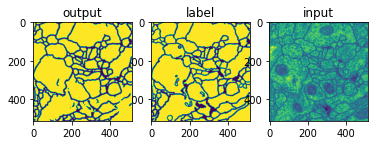

In [34]:
plt.subplot(132)
plt.imshow(label)
plt.title('label')

plt.subplot(133)
plt.imshow(input)
plt.title('input')

plt.subplot(131)
plt.imshow(output)
plt.title('output')

plt.show()